In [14]:
import numpy as np
%load_ext autoreload
%autoreload 2
import torch
from alphatoe import plot, game, evals, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TODO: Make game.play_game work without 10's or 9's

The model correctly infers that the game ends at token 5, so it's next guess is the end of game token 9

This project is about doing interpretability on a model that understands tic-tac-toe. We use a 1 layer 8 head transformer with a residual stream size of 128. Whenever we make a query of the model, we ask it in the following form: `[start_game_token, player1_move1, player2_move1, player1_move2, etc]`. The start_game_token is 10, and the potential moves are the ints 0 to 8. Here's an example game:

In [49]:
# Indices go from left to right, top to bottom
# 0 is the top left, 1 is top middle, etc.
# 10 is the start of game token, and 9 is the end of game token
example_game = [10, 0, 1, 2, 3, 4, 5, 6]
game.play_game(example_game)

| X | O | X |
| O | X | O |
|   |   |   |


Now let's load up the model and see what we're working with

In [20]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

Everything in this stage of the project is concerned with understanding how the model knows when to predict 9 (the end of game token). If we ask the model to predict the next token in our previous game, it should predict 9

In [51]:
# The last index of our logit is the end of game token, and we see it correctly predicts that!
logits = model(torch.tensor(example_game))
print(logits.shape)
print(logits[0, -1])

torch.Size([1, 8, 10])
tensor([-23.9999,   3.9674, -21.2261,   4.0562, -17.1209,   4.1609, -22.9341,
         13.0733,  13.2345,  26.3882], device='cuda:0',
       grad_fn=<SelectBackward0>)


Our model should never predict 10 (the start of game token), so the logits correspond to each possible tic tac toe move and the end of game token. i.e. {0...9}

We can see the predictions more clearly with a heatmap

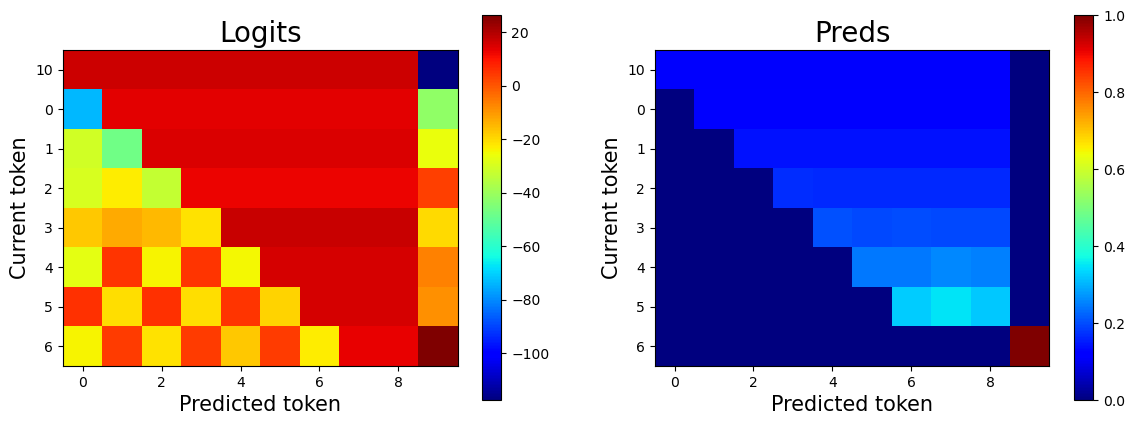

In [52]:
interpretability.plot_predictions(example_game, logits)

Just like we thought, the network is extremely confident that 9 is the next token after move 6 was played. Two quick notes: 
1. The network is trained to predict a uniform probability distribution across all the potential next moves
2. We see some interesting checkerboard patterning occuring in the logits, we'll see later where we think that comes from

We also have a set of evals that we can run to check how effective the model is at correctly guessing move 9

In [43]:
sampled_games: list[list[int]] = evals.sample_games(model, temp=0.90, num_games=1000)
evals.eval_model(sampled_games)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 198.42it/s]
1000it [00:00, 20127.38it/s]


{'_check_played_repeat_moves': 0.0,
 '_check_played_after_player_victory': 0.0,
 '_check_played_after_draw_game': 0.0,
 'inappropriate_end_state': 0.0,
 '_check_if_illegal_moves': 0.0}

This eval lists the kind of error we're concerned about, along with how often it makes that error in the sampled games. This shows that the model never guesses the same move twice. It always guesses 9 after a player has drawn or won, etc. So we know our model understands the rules of tic-tac-toe.

Attention is the fanciest part of a transformer, so let's take a look at the attention of our model on our example game.

In [53]:
print(example_game)
str_tokens = [str(token) for token in example_game]
logits, cache = model.run_with_cache(
    torch.tensor(example_game).to("cuda"), remove_batch_dim=True
)

print(type(cache))
attention_pattern = cache["pattern", 0, "attn"]
print(attention_pattern.shape)
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

[10, 0, 1, 2, 3, 4, 5, 6]
<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([8, 8, 8])


This looks like the checkerboard battern we spotted earlier! It only starts occuring after 5 moves have been played (not counting the token 10). This makes sense, as when the model tries determining if the game is over, it only needs to care about the most recent players moves.

Let's further investigate the effects of ablating the attention mechanism.

We'll use a longer game for this that ends in a draw.

In [88]:
# It's invalid because the game continues after move 6
new_game = [10, 0, 1, 2, 6, 5, 8, 4, 3, 7]
gm = game.play_game(new_game)
gm.get_state()

| X | O | X |
| O | X | X |
| O | X | O |


<State.DRAW: 0>

Here's our logits pre-ablation. Check out how it predicts 9 after token 7 has been played

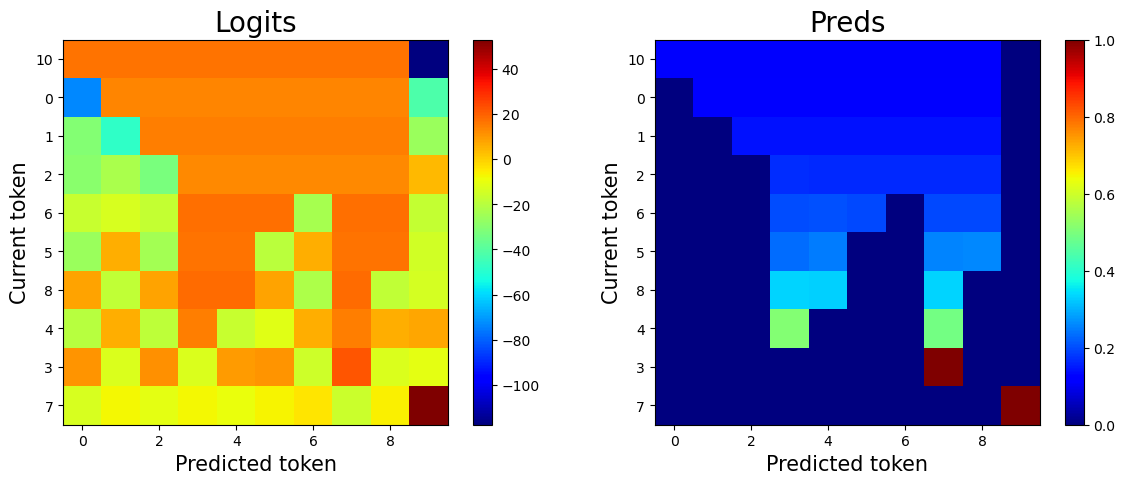

In [89]:
interpretability.plot_predictions(
    new_game, model(torch.tensor(new_game, requires_grad=False))
)

Now let's ablate the attention mechanism 

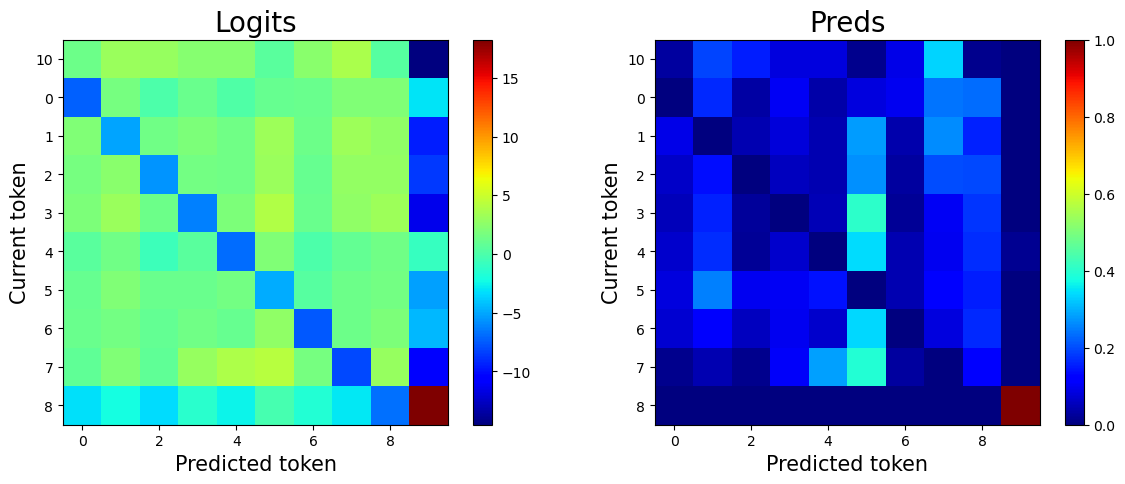

In [92]:
def zero_output(module, input, output):
    return torch.zeros_like(output)


handles = []
handles.append(model.blocks[0].attn.register_forward_hook(zero_output))
interpretability.plot_predictions(seq_fwd, model(torch.tensor(seq_fwd)))
[h.remove() for h in handles]
handles = list()

1. The model never predicts the token it was passed, but has no memory of previous moves
2. It still correctly predicts the game's over, even without attention!

This means knowing when a game is a draw must involve the embeddings (embedding, unembedding and positional) and the MLP

Note: A game is always over after 9 moves have been played. Either a player won, or the game is a draw. Since token 9 is the generic 'game over' token, this means the model will always predict token 9 after 9 moves have been played

Let's check how the positional embedding interacts with various parts of the model

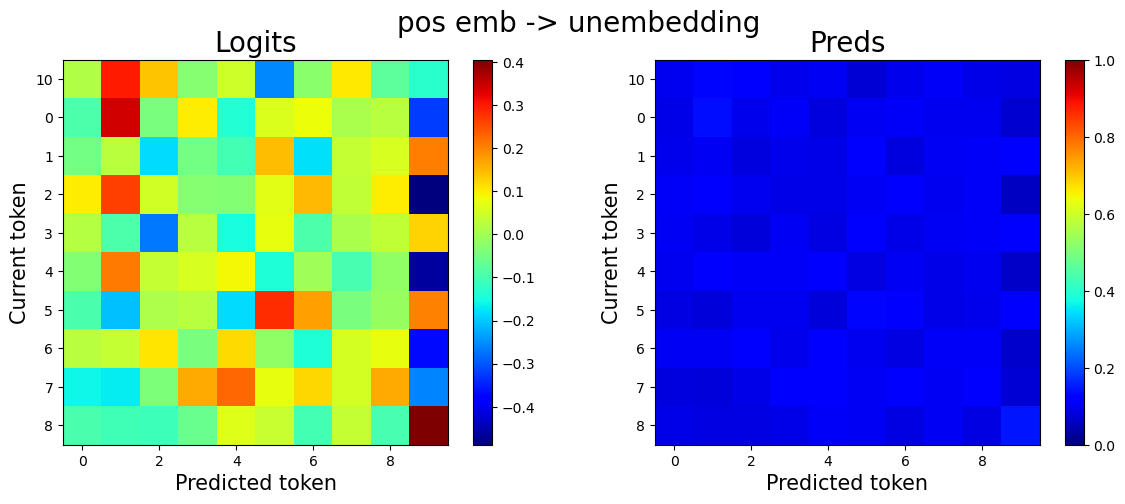

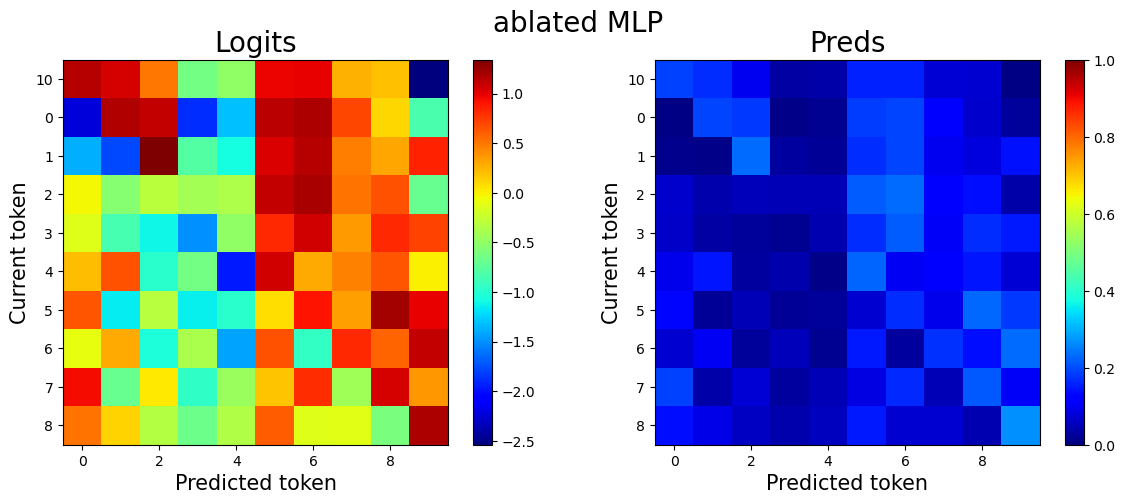

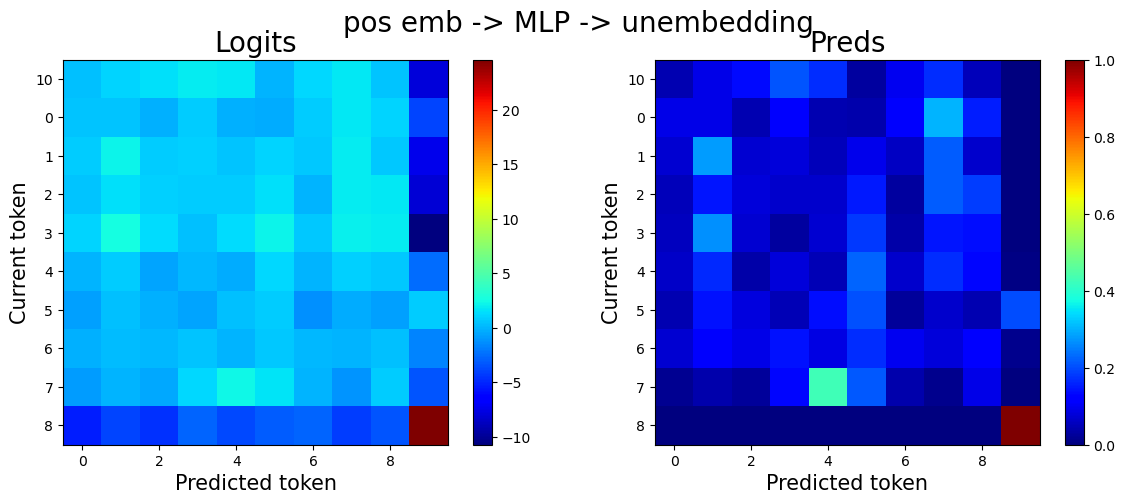

In [99]:
# generic positional embedding for our game
pos_emb = model.pos_embed(torch.zeros(1, 10), 0)
# pass embedding data through the MLP only
logits_mlp_pos = model.blocks[0].mlp(pos_emb) @ model.W_U
# directly unembed the positional embedding
logits_pos = pos_emb @ model.W_U
interpretability.plot_predictions(
    seq_fwd, logits_pos, suptitle="pos emb -> unembedding"
)
interpretability.plot_predictions(
    seq_fwd, interpretability.ablate_mlp(model, seq_fwd), suptitle="ablated MLP"
)
interpretability.plot_predictions(seq_fwd, logits_mlp_pos, suptitle="pos")

When we ablate the MLP, the model still somewhat correctly predicts the end game token. But if we use just the MLP, the model predicts it perfectly! This is a smoking gun: The model uses the MLP and positional information to predict token 9 when 9 moves have been played  

To understand this in more depth, we'll need to dig into the MLP, and to do that we'll need to understand a bit more about the dataset

There are ~255k possible games of tic-tac-toe, and just over half of those games end in 9 moves. Our MLP has 512 neurons in it. If we take the average loss of ablating a neuron across all 255k games, we should be able to see something interesting.

### Details about plot generation, feel free to skip

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [102]:
ablations_df = pd.read_csv("../data/230807_mlp_neuron_ablations.csv")
losses_df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
print(losses_df.columns)
print(ablations_df.columns)

Index(['moves played', 'steps till end state', 'winner', 'rotation 1',
       'rotation 2', 'rotation 3', 'horizontal flip', 'vertical flip',
       'training index', 'train or test', 'first win condition',
       'second win condition', 'end move loss'],
      dtype='object')
Index(['moves played', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=513)


/tmp/ipykernel_4508/3902525130.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  losses_df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


In [103]:
losses_df = losses_df[["moves played", "first win condition", "end move loss"]]
# convert ablations_df to object
ablations_df = ablations_df.astype(object)

In [104]:
ablations_df["moves played"] = losses_df["moves played"]

In [105]:
ablations_df.head()

,moves played,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,"[0, 1, 3, 2, 6]",0.000008,0.000008,0.000497,0.00001,0.000001,1.097605,0.000004,0.000005,0.000002,...,0.000005,0.0,0.000003,0.000004,0.000002,0.000005,0.000006,0.000008,0.000051,0.000006
1,"[0, 1, 3, 4, 6]",0.000195,0.000189,0.036626,0.000232,0.000003,3.076243,0.000077,0.000098,0.000029,...,0.000118,0.000012,0.000041,0.000081,0.000042,0.0001,0.000123,0.000181,0.000794,0.000149
2,"[0, 1, 3, 5, 6]",0.000011,0.000011,0.000807,0.000013,0.0,1.423348,0.000005,0.000005,0.000003,...,0.000006,0.000001,0.000002,0.000003,0.000003,0.000005,0.000007,0.00001,0.000073,0.000009
3,"[0, 1, 3, 7, 6]",0.000015,0.000014,0.00213,0.000017,0.000001,1.009675,0.000005,0.000007,0.000003,...,0.000009,0.000001,0.000003,0.000005,0.000004,0.000008,0.000008,0.000012,0.000072,0.00001
4,"[0, 1, 3, 8, 6]",0.000022,0.000021,0.001409,0.000025,0.000001,1.193816,0.00001,0.00001,0.000005,...,0.000014,0.000001,0.000008,0.000009,0.000005,0.000012,0.000013,0.000019,0.00013,0.000016


In [106]:
merged_df = pd.merge(ablations_df, losses_df, on="moves played", how="inner")

In [107]:
def add_epsilon(val, column):
    if column in ["moves played", "first win condition"]:
        return val
    return val + 10e-8


merged_df = merged_df.apply(lambda col: col.map(lambda val: add_epsilon(val, col.name)))

merged_df.iloc[-1]

moves played           [8, 7, 6, 5, 4, 3, 1, 2, 0]
0                                              0.0
1                                              0.0
2                                              0.0
3                                              0.0
                                  ...             
509                                            0.0
510                                            0.0
511                                            0.0
first win condition       top left -> bottom right
end move loss                                  0.0
Name: 255167, Length: 515, dtype: object

In [108]:
for col in merged_df.columns:
    if col not in ["moves played", "end move loss", "first win condition"]:
        merged_df[col] = np.log10(merged_df[col] / merged_df["end move loss"])

normalized_ablation_losses_df = merged_df.drop(columns=["end move loss"])

In [109]:
normalized_ablation_losses_df.head()
# count all nans
normalized_ablation_losses_df.isna().sum().sum()

46080

In [113]:
losses_df = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
# first row where moves played is >5
game_position_5 = losses_df[losses_df["steps till end state"] > 5].index[0]
game_position_6 = losses_df[losses_df["steps till end state"] > 6].index[0]
game_position_7 = losses_df[losses_df["steps till end state"] > 7].index[0]
game_position_8 = losses_df[losses_df["steps till end state"] > 8].index[0]

/tmp/ipykernel_4508/1247561056.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  losses_df = pd.read_csv('../data/prob all 8 layer control-20230718-185339_stats.csv')


IndexError: index 0 is out of bounds for axis 0 with size 0

### The Plot

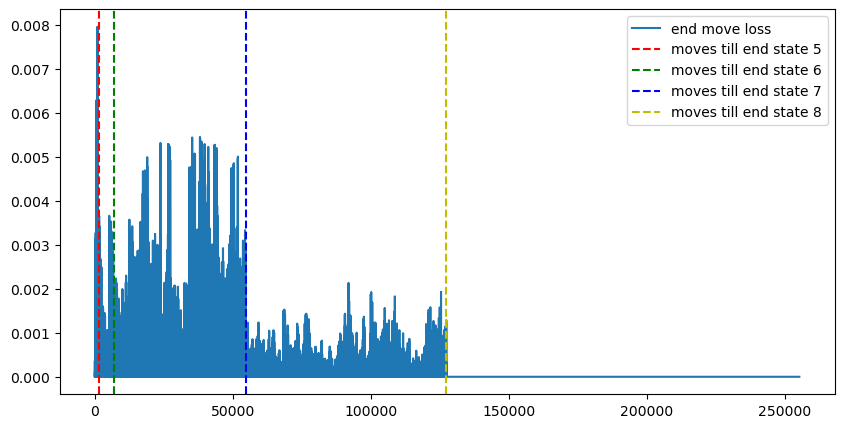

In [111]:
# plot losses_df 'moves played' vs 'end move loss'
plt.figure(figsize=(10, 5))
# fig dpi
plt.rcParams["figure.dpi"] = 300
plt.plot(losses_df["end move loss"], label="end move loss")
# plot vertical line at game_position_5
plt.axvline(
    x=game_position_5, color="r", linestyle="--", label="moves till end state 5"
)
plt.axvline(
    x=game_position_6, color="g", linestyle="--", label="moves till end state 6"
)
plt.axvline(
    x=game_position_7, color="b", linestyle="--", label="moves till end state 7"
)
plt.axvline(
    x=game_position_8, color="y", linestyle="--", label="moves till end state 8"
)
# legend
plt.legend(loc="upper right")
plt.show()

This graph partitions the total games by how long they take to finish, with our example game existing in the last half of this graph. The y axis is the average loss caused by ablating an arbitrary neuron in the MLP.   

The key feature is that the average loss goes to ~0 in the last half. 

Why? Our hypothesis is that a large portion of neurons are responsible for taking in the positional information, so that ablating any particular neuron has a negligable effect on the loss. If you look at the predictions of the "pos emb -> mlp -> unembedding" plot above, the logit value for token 9 is ~24, while the logit value for *any* of the other tokens is at most, -5. This means the marginal change in the predictions by ablating, say, one neuron out of 100, is incredibly small, especially after we take the softmax into account.

### Some code demonstrating the effect, feel free to skip


In [115]:
loss_fn = torch.nn.functional.cross_entropy

In [120]:
# target is 1,0. Our psuedo logits aim for this
target = torch.tensor([1.0, 0.0])

positive_contributions = torch.randn(100) + 1
negative_contributions = torch.randn(100) - 1
# simulate some neuron activations
neuron_contributions = torch.stack([positive_contributions, negative_contributions])

# add them together
sum_contributions = einops.reduce(
    neuron_contributions, "logits neurons -> logits", "sum"
)

# our loss is now 0
loss = loss_fn(sum_contributions, target)
print(loss)

# we ablate some neurons
ablated_neurons = neuron_contributions[:, 10:13] = 0.0

# add them together
ablated_sum_contributions = einops.reduce(
    ablated_neurons, "logits neurons -> logits", "sum"
)

# our loss is now 0
loss = loss_fn(sum_contributions, target)

torch.Size([2, 100])
tensor(-0.)


We know that 

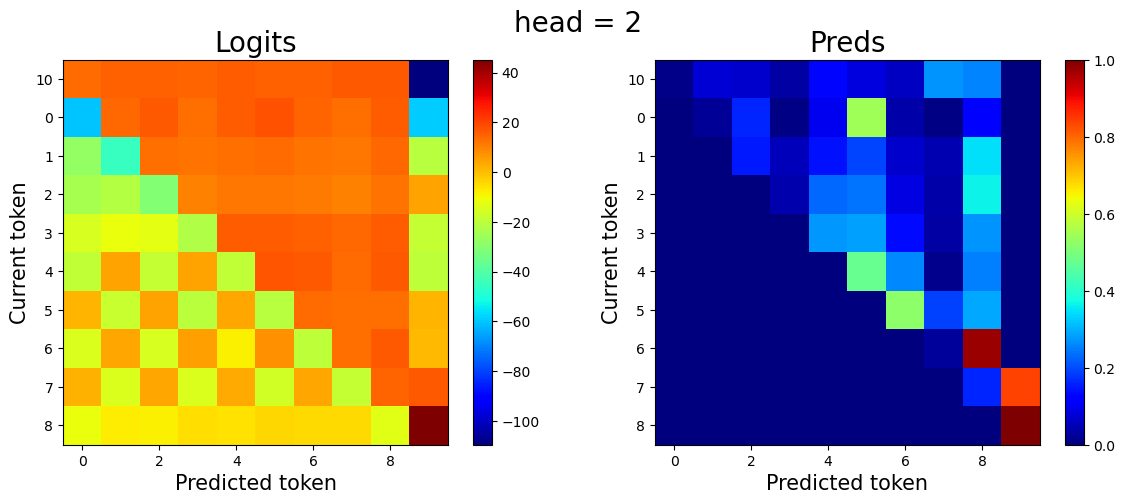

In [21]:
interpretability.plot_predictions(
    seq_fwd, interpretability.ablate_one_head(model, 2, seq_fwd), suptitle="head = 2"
)

Remember, this game should be over when token 6 is played. But when we ablate the output of head 2, we can see that the model no longer believes the game is over when token 6 is played. We can confirm that 2 is the main responsible head by  checking the behavior when ablating the other heads

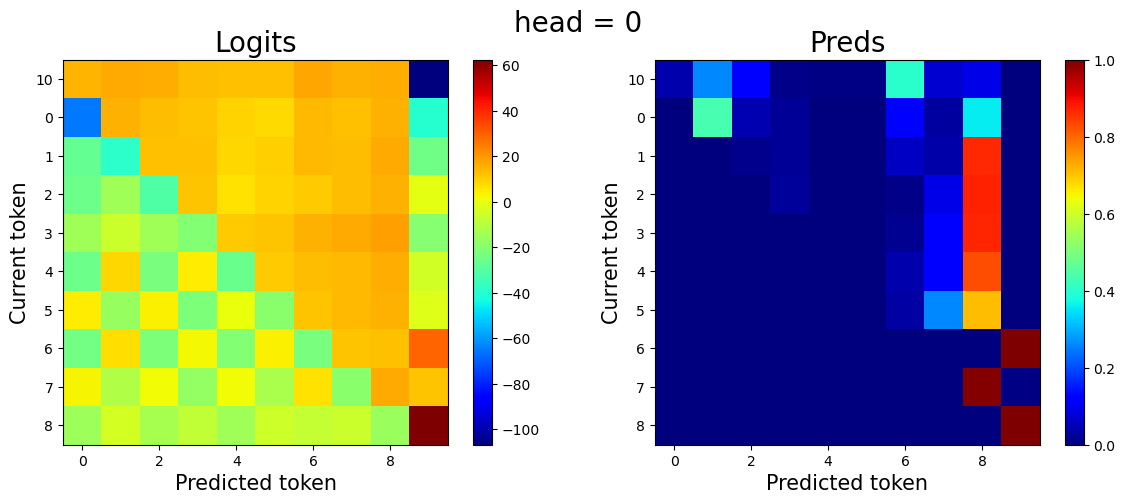

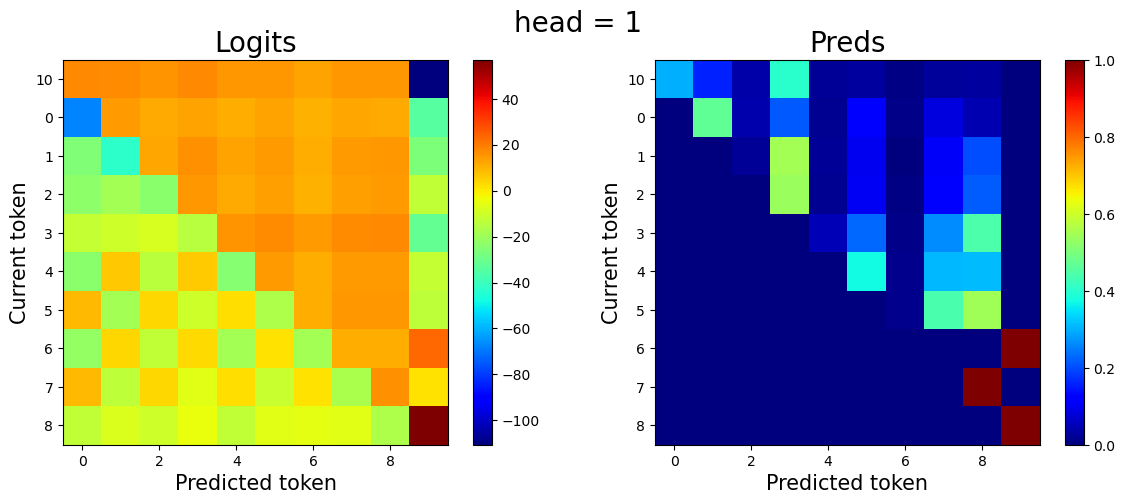

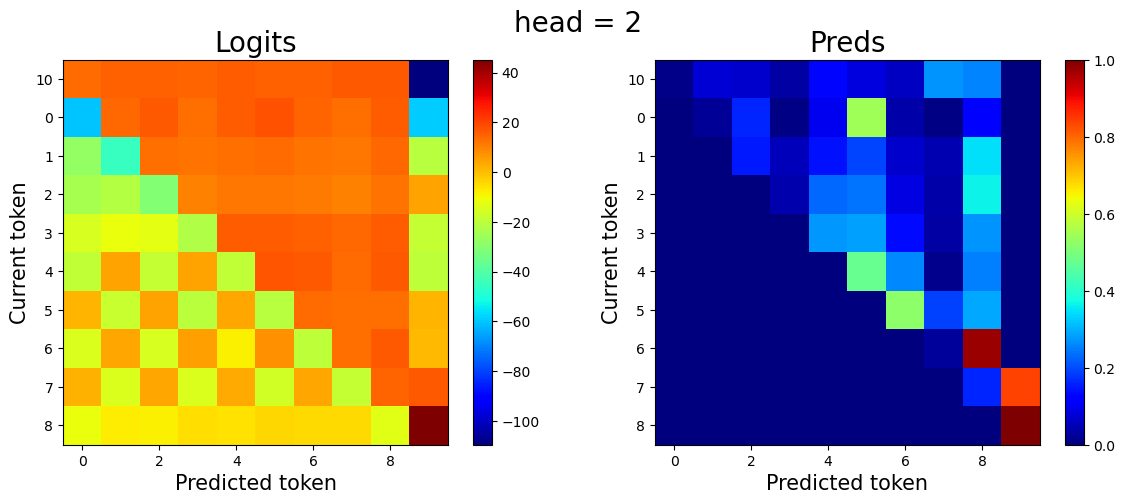

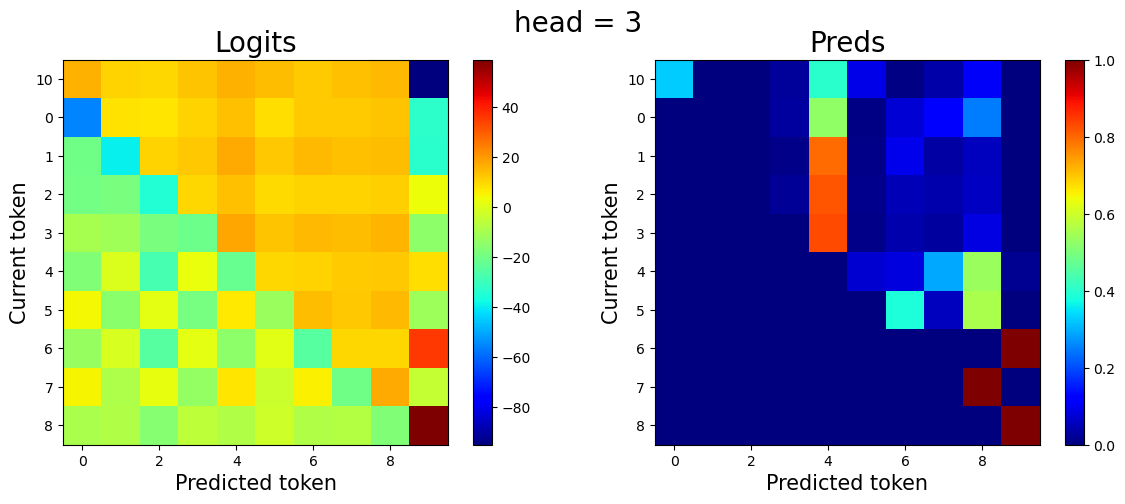

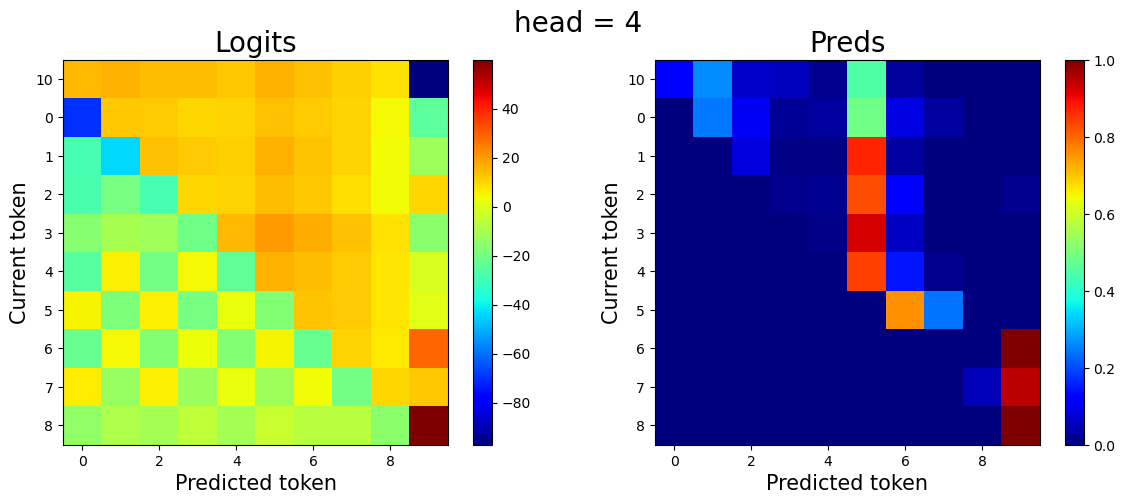

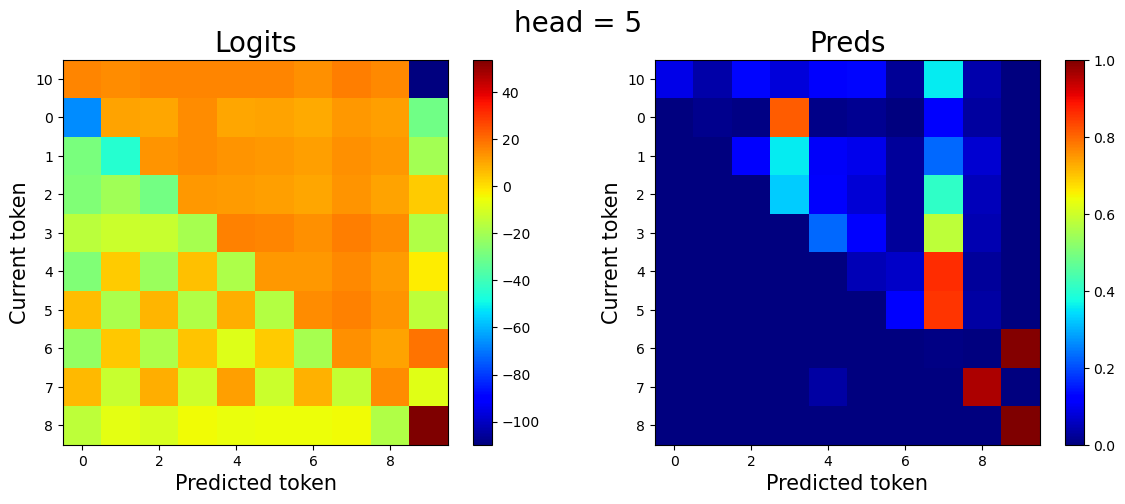

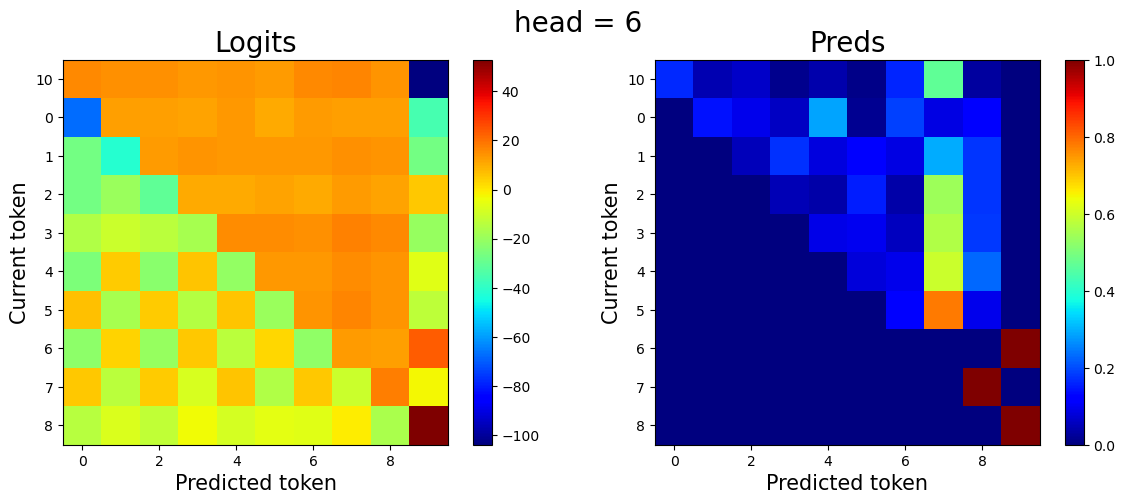

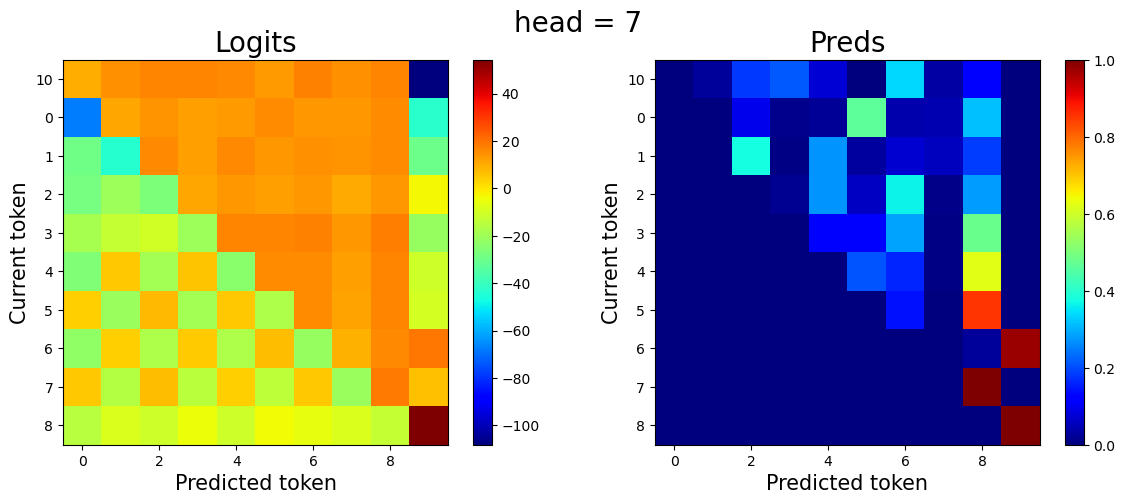

In [22]:
for i in range(8):
    interpretability.plot_predictions(
        seq_fwd, interpretability.ablate_one_head(model, i, seq_fwd), f"head = {i}"
    )

This confirms that head 2 is the most important for determining end state, at least for this particular game. We've also confirmed this behavior across the other end conditions.